In [1]:
import ast_preprocess_dataloader
from ast_preprocess_dataloader import AudioPipeline
import torchaudio
import torch
import os
import glob
from torch.utils.data import Dataset, DataLoader
from audiomentations import Compose, TimeStretch, PitchShift, BandPassFilter, AddBackgroundNoise, Normalize
import numpy as np
from transformers import AutoProcessor, ASTConfig, ASTModel, ASTForAudioClassification, AutoModelForAudioClassification
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa
import torch.nn.functional as F

C:\Users\dave\anaconda3\envs\haikoo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("PyTorch is using GPU 🟢")
else:
    device = torch.device("cpu")
    print("PyTorch is using CPU 🟡")

PyTorch is using GPU 🟢


In [3]:
cwd = os.getcwd()
cwd

'C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\modeling\\modeling_renewal\\pipeline2'

In [4]:
dataset_dir = r"C:\Users\dave\aiffel\EUANGGG\maincode\data\dataset\audioonly\labeled\orig_resample"
os.path.exists(dataset_dir)

True

In [5]:
class_name = os.listdir(dataset_dir)
class_name

['bellypain', 'discomfort', 'hungry', 'tired']

In [6]:
audio_dir = [os.path.join(dataset_dir, name) for name in class_name]
audio_dir

['C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\dataset\\audioonly\\labeled\\orig_resample\\bellypain',
 'C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\dataset\\audioonly\\labeled\\orig_resample\\discomfort',
 'C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\dataset\\audioonly\\labeled\\orig_resample\\hungry',
 'C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\dataset\\audioonly\\labeled\\orig_resample\\tired']

In [7]:
bpain_audio = glob.glob(os.path.join(audio_dir[0], '*.wav'))
discomf_audio = glob.glob(os.path.join(audio_dir[1], '*.wav'))
hungry_audio = glob.glob(os.path.join(audio_dir[2], '*.wav'))
tired_audio = glob.glob(os.path.join(audio_dir[3], '*.wav'))

In [8]:
audio_path_class = {
    'bpain': bpain_audio,
    'discomf': discomf_audio,
    'hungry': hungry_audio,
    'tired': tired_audio
}

In [9]:
all_paths = []
all_labels = []

for (label, class_name), path_lst in zip(enumerate(audio_path_class), audio_path_class.values()):
    for path in path_lst:
        all_paths.append(path)
        all_labels.append(label)

In [10]:
from collections import Counter

Counter(all_labels)

Counter({3: 50, 0: 49, 2: 49, 1: 47})

## **훈련, 검증, 테스트 경로 쪼개기**

In [11]:
train_paths, val_paths, train_labels, val_labels = train_test_split(all_paths, all_labels, test_size=0.3, random_state=42)

In [12]:
# 갯수 확인
print(len(train_paths))
print(len(val_paths))
print(len(train_labels))
print(len(val_labels))

136
59
136
59


In [13]:
val_paths, test_paths, val_labels, test_labels = train_test_split(val_paths, val_labels, test_size=0.5, random_state=42)

In [14]:
# 갯수 확인
print(len(val_paths))
print(len(test_paths))
print(len(val_labels))
print(len(test_labels))

29
30
29
30


## **파이프라인 만들기**

In [15]:
augmentations = Compose([
    # AddBackgroundNoise(sounds_path = noise_path,
    #                    min_snr_db=17,
    #                    max_snr_db=17,
    #                    p=0.3),
    # TimeStretch(min_rate=0.9, max_rate=1.1, p=0.5),
    # PitchShift(min_semitones=-1.1, max_semitones=1.1, p=0.5),
    BandPassFilter(min_center_freq=1500, max_center_freq=1500,
                   max_bandwidth_fraction=1.33, min_bandwidth_fraction=1.33,
                   max_rolloff=12, min_rolloff=12, p=1.0),
    # Normalize(p=1.0)
])

train_dataset = AudioPipeline(audio_paths=train_paths, audio_labels=train_labels, sr=20000, transform=augmentations)
val_dataset = AudioPipeline(audio_paths=val_paths, audio_labels=val_labels, sr=20000)
test_dataset = AudioPipeline(audio_paths=test_paths, audio_labels=test_labels, sr=20000)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be remo

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)

## **모델 불러오기**

In [17]:
class CustomASTClassifier(nn.Module):
    def __init__(self, ast_model_name, num_labels):
        super().__init__()
        self.config = ASTConfig()
        self.num_labels = num_labels
        self.ast = ASTModel.from_pretrained(ast_model_name)
        for param in self.ast.parameters():
            param.requires_grad = False

        self.classifier = nn.Linear(300, self.num_labels)
        self.dense1 = nn.Linear(self.config.hidden_size, 300)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, input_values, labels=None):
        input_values = input_values.float()
    
        # Use self to refer to the current instance and its attributes/methods
        outputs = self.ast(input_values)
        embeddings = outputs.last_hidden_state
        pooled_output = outputs.pooler_output
        sum_output = (pooled_output+embeddings[:, 1] / 2)
        x = self.dense1(sum_output)
        x = self.activation(x)
        logits = self.classifier(x)
    
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            # Calculate the loss directly with the logits and labels
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1).long())
            return loss, logits
        
        return logits, None  # Adjusted to return None for loss when labels are not provided

In [18]:
num_labels = 4
ast_model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
model = CustomASTClassifier(ast_model_name, num_labels).to(device)

# Define your optimizer, loss function, etc.
optimizer = optim.Adam(model.parameters(), lr=1.99526231496888e-05)
# 1.737800828749376e-08

# Initialize metric lists
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

In [19]:
for name, param in model.ast.named_parameters():
    if param.requires_grad:
        print(f"{name}: requires_grad is True")
    else:
        print(f"{name}: requires_grad is False")

embeddings.cls_token: requires_grad is False
embeddings.distillation_token: requires_grad is False
embeddings.position_embeddings: requires_grad is False
embeddings.patch_embeddings.projection.weight: requires_grad is False
embeddings.patch_embeddings.projection.bias: requires_grad is False
encoder.layer.0.attention.attention.query.weight: requires_grad is False
encoder.layer.0.attention.attention.query.bias: requires_grad is False
encoder.layer.0.attention.attention.key.weight: requires_grad is False
encoder.layer.0.attention.attention.key.bias: requires_grad is False
encoder.layer.0.attention.attention.value.weight: requires_grad is False
encoder.layer.0.attention.attention.value.bias: requires_grad is False
encoder.layer.0.attention.output.dense.weight: requires_grad is False
encoder.layer.0.attention.output.dense.bias: requires_grad is False
encoder.layer.0.intermediate.dense.weight: requires_grad is False
encoder.layer.0.intermediate.dense.bias: requires_grad is False
encoder.laye

In [20]:
# Training loop
for epoch in range(40):  
    total_loss, correct, total = 0, 0, 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")

    # Training phase
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_values, labels = batch
        input_values, labels = input_values.to(device), labels.to(device)

        loss, logits = model(input_values, labels)
        total_loss += loss.item()

        # Calculate accuracy
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item())

    train_accuracy = correct / total
    train_losses.append(total_loss / len(train_dataloader))
    train_accuracies.append(train_accuracy)

    # Validation phase
    if val_dataloader is not None:
        model.eval()
        with torch.no_grad():
            val_loss, correct, total = 0, 0, 0
            for batch in val_dataloader:
                input_values, labels = batch
                input_values, labels = input_values.to(device), labels.to(device)

                loss, logits = model(input_values, labels)
                val_loss += loss.item()
                preds = logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            val_accuracy = correct / total
            val_losses.append(val_loss / len(val_dataloader))
            val_accuracies.append(val_accuracy)

        model.train()

Epoch 1:   0%|                                                                       | 0/14 [00:13<?, ?it/s, loss=1.31]

Epoch 3:   0%|                                                                       | 0/14 [00:12<?, ?it/s, loss=1.32]

Epoch 5:   0%|                                                                      | 0/14 [00:11<?, ?it/s, loss=0.966]

Epoch 7:   0%|                                                                      | 0/14 [00:11<?, ?it/s, loss=0.997]

Epoch 9:   0%|                                                                       | 0/14 [00:11<?, ?it/s, loss=1.14]

Epoch 11:   0%|                                                                      | 0/14 [00:11<?, ?it/s, loss=1.23]

Epoch 13:   0%|                                                                      | 0/14 [00:11<?, ?it/s, loss=1.09]

Epoch 15:   0%|                                                                     | 0/14 [00:11<?, ?it/s, loss=0.851]

Epoch 17:   0%|                 

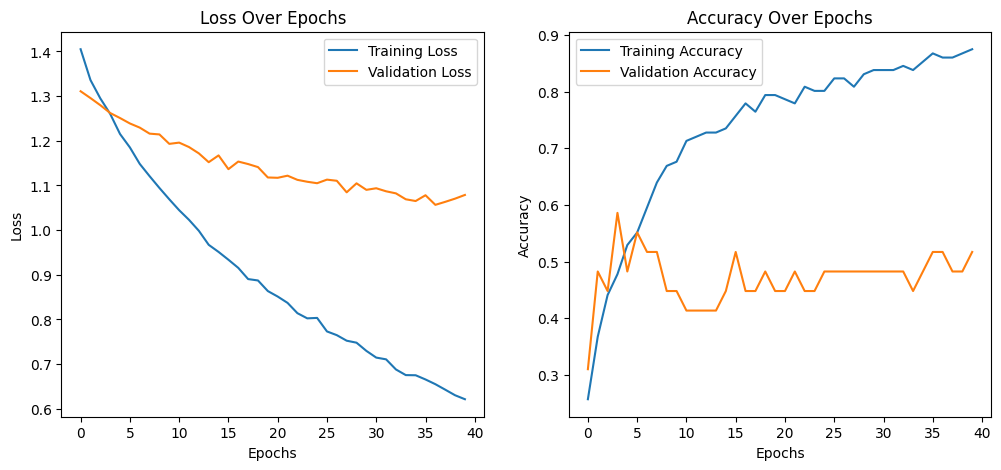

In [21]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
if val_dataloader is not None:
    plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
if val_dataloader is not None:
    plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("pip2_renewal_dense1(300)lrelu_epc40_dnn_pooler_seqadd.png") # 그래프 사진은 주석풀어서 사진이름만 설정해주시면 됩니다.

plt.show()

In [22]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0
with torch.no_grad():  # Disable gradient computation
    for data in test_dataloader:  # dataloader is your DataLoader for the dataset
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        logits = outputs[0]  # Access the logits directly
        _, predicted = torch.max(logits, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 53.33%
